<a href="https://colab.research.google.com/github/sheffalee/WebHelpers/blob/main/sheffalee_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODEL BUILDING

The models i built are:
1.Roberta
2.Vader

1.Roberta:
Roberta, developed by Facebook AI, enhances BERT through robust pretraining and more data.It achieves state-of-the-art results on various NLP tasks due to its deeper language understanding.
The model has proven effective in a wide range of applications, from language translation to question answering.Roberta's training process involves removing the next sentence prediction task and using larger batch sizes.These improvements contribute to its superior performance over BERT in many natural language processing benchmarks.

Advantages of Roberta:
Improved NLP model by Facebook AI, outperforms BERT with robust pretraining and larger data.Broader language understanding, better handling of informal language, and domain-specific jargon.Generalizes well across tasks, advancing NLP research and enabling practical applications.

2.Vader:
VADER, or Valence Aware Dictionary and sEntiment Reasoner, is a lexicon-based sentiment analysis tool.It excels in analyzing social media content, considering nuances and informal language.
VADER employs a human-annotated lexicon to determine sentiment scores for words, capturing intensity and negations.Its design enables accurate sentiment analysis for short texts, such as tweets and posts.VADER's effectiveness and simplicity make it a popular choice for social media monitoring and opinion mining.

Advantages of Vader:
Lexicon-based sentiment analysis tool for social media text, capturing nuances effectively.Considers word polarity, intensity, negations, and punctuation for accurate sentiment analysis.Fast, simple, and versatile, influencing sentiment analysis research and industry applications.

I built few models and analysed among these Roberta and Vader where the best performing models.So i would suggest vader and roberta as the best models that can be used in the implementation of the WebHelpers project.

Link for the dataset :https://drive.google.com/file/d/1CZpQwEXjFiqq4YBwz8QDYsuV18b5moaZ/view?usp=sharing

The dataset is very large so i have taken only few rows for the model building and training.

To avoid errors , make sure you install all the packages used in this code in your environment.

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk

In [2]:
df = pd.read_csv('Reviews.csv',nrows =200)
print(df.shape)
#I have used a very large dataset consisting of 5lakhs of records.
# In order to decrease the runtime you can modify the number of records
# you needed depending on the GPU availability.
# df = df.head(500)
# print(df.shape)

(200, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


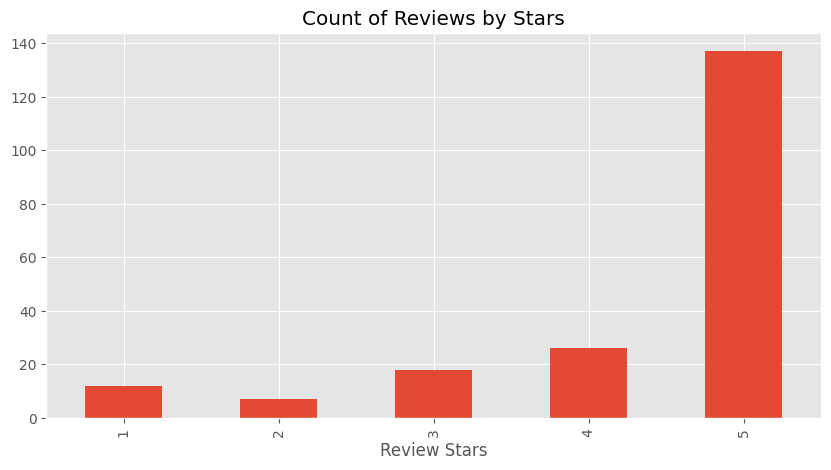

In [4]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [5]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:

import nltk
nltk.download('punkt')

tokens = nltk.word_tokenize(example)
tokens[:10]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
nltk.download('averaged_perceptron_tagger')

tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [8]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
sia.polarity_scores('I am so happy!')


{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This is the worst thing ever.')


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


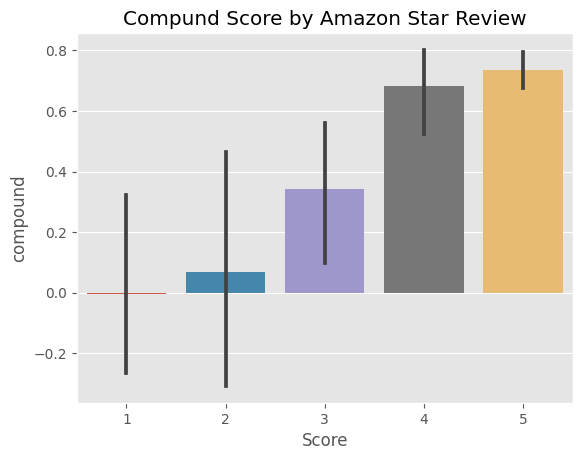

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

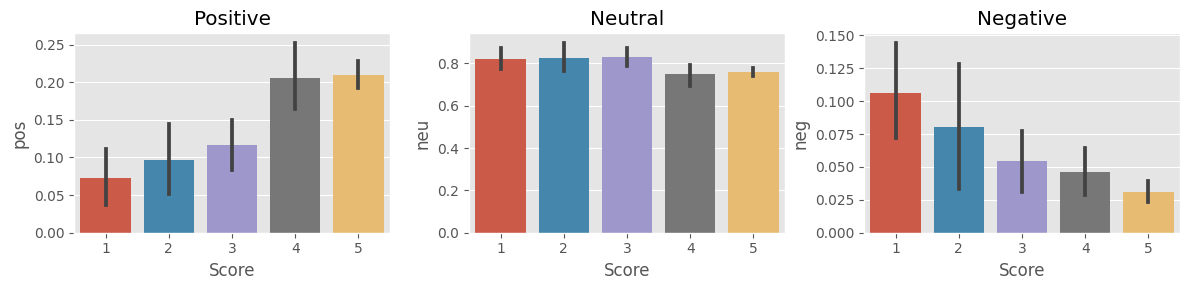

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [18]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.8 MB/s eta 0:00:00


In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
example = df['Text'][50]
print(example)
encoded_text = tokenizer(example, return_tensors='pt')
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

with torch.no_grad():
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = output.logits

scores = torch.softmax(logits, dim=1)
scores_dict = {
    'roberta_neg': scores[0, 0].item(),
    'roberta_neu': scores[0, 1].item(),
    'roberta_pos': scores[0, 2].item()
}
print(scores_dict)



This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
{'roberta_neg': 0.9763551354408264, 'roberta_neu': 0.02068747580051422, 'roberta_pos': 0.0029573722276836634}


In [21]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/200 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [24]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [25]:
#Compare scores between models

results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

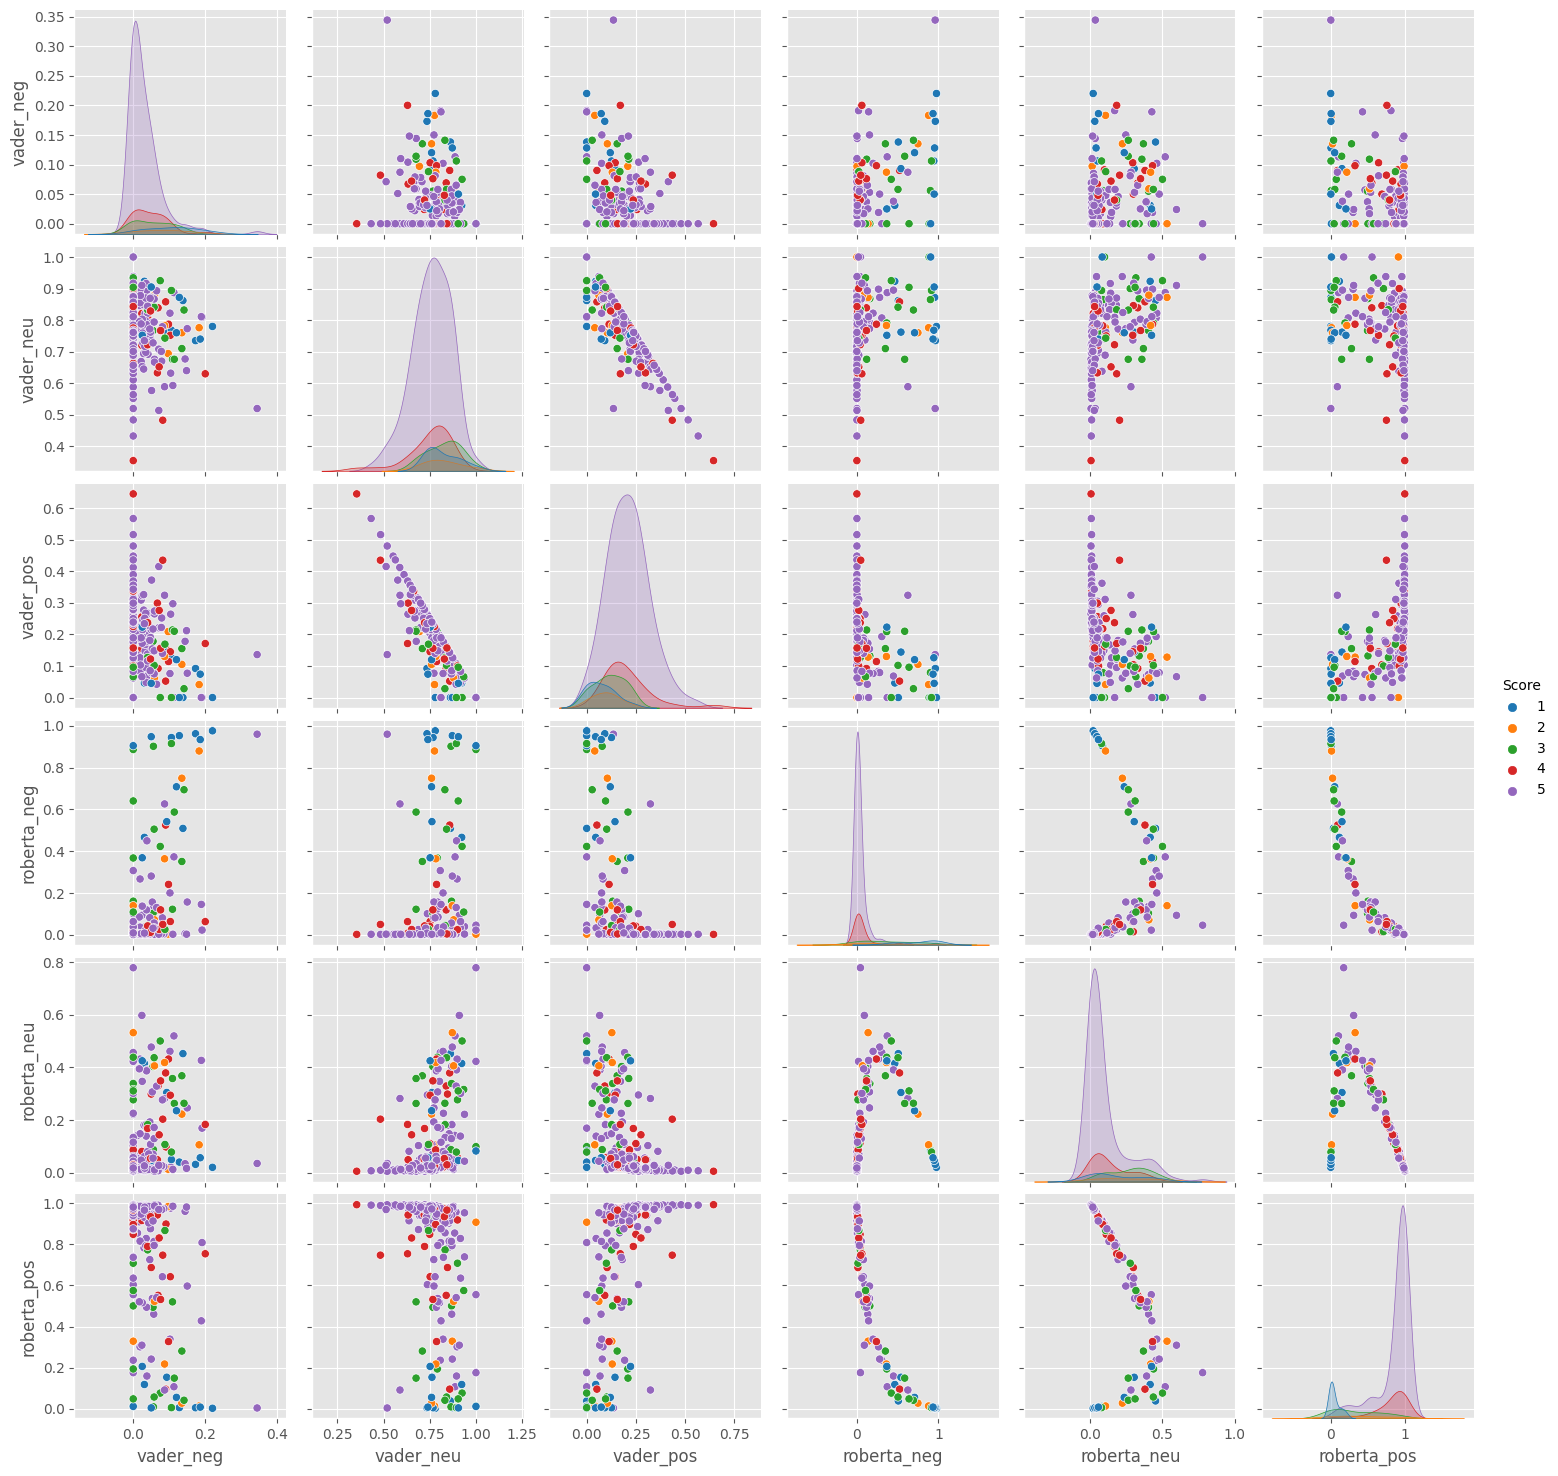

In [26]:
#Combine and compare
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()



In [27]:
#Review examples
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor.'

In [28]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor.'

In [29]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [30]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Get input text from the user
user_input = input("Please enter your sentence: ")

# Print the user's input
print("Example: ", user_input)

# Get the sentiment polarity scores using SentimentIntensityAnalyzer
scores = sia.polarity_scores(user_input)

# Print the sentiment polarity scores
print("Sentiment Polarity Scores:")
print("Positive: ", scores['pos'])
print("Negative: ", scores['neg'])
print("Neutral: ", scores['neu'])
print("Compound: ", scores['compound'])

if scores['pos'] >scores['neg'] and scores['pos']>scores['neu']:
  sentiment_label ='positive'
elif scores['neg']>scores['pos'] and scores['neg']>scores['neu']:
  sentiment_label ='negative'
else:
  sentiment_label='neutral'

print("Sentiment: ", sentiment_label)


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle

# Download VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

def get_sentiment_label(sentence):
    # Create a SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Get the sentiment polarity scores using SentimentIntensityAnalyzer
    scores = sia.polarity_scores(sentence)

    if scores['pos'] > scores['neg'] and scores['pos'] > scores['neu']:
        sentiment_label = 'positive'
    elif scores['neg'] > scores['pos'] and scores['neg'] > scores['neu']:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    return sentiment_label

# Get input text from the user
user_input = input("Please enter your sentence: ")

# Print the user's input
print("Example: ", user_input)

# Get the sentiment label using the provided function
sentiment_label = get_sentiment_label(user_input)

# Print the sentiment label
print("Sentiment: ", sentiment_label)

# Serialize the function to create the pickle file
with open('sentiment_analysis_model.pkl', 'wb') as file:
    pickle.dump(get_sentiment_label, file)
